In [1]:
!pip install xarray
!pip install netCDF4
!pip install sweetviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.0 which is incompatible.
jupyterlab 4.1.6 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.p

In [2]:
import pathlib
import xarray as xr
import os
import netCDF4 as nc
import pandas as pd
import sweetviz as sv
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import missingno as msno


In [3]:
file_path = '/kaggle/input/82-23-three-hours-era5-correct/adaptor.mars.internal-1714829848.6502414-12195-14-d84c80b7-71bf-4f45-bb00-b82d40ab38d4.nc'
filtered_file_path = '/kaggle/working/filtered_data_from_2004.nc'

In [4]:
dataset = xr.open_dataset(file_path, chunks={'time': 1000})
dataset = dataset.sortby('time')
# dataset = xr.open_dataset(filtered_file_path)

print(dataset)

<xarray.Dataset> Size: 14GB
Dimensions:     (longitude: 201, latitude: 41, expver: 2, time: 2028)
Coordinates:
  * longitude   (longitude) float32 804B 120.0 120.2 120.5 ... 169.5 169.8 170.0
  * latitude    (latitude) float32 164B 5.0 4.75 4.5 4.25 ... -4.5 -4.75 -5.0
  * expver      (expver) int32 8B 1 5
  * time        (time) datetime64[ns] 16kB 1982-01-01 ... 2024-03-02
Data variables: (12/54)
    u10         (time, expver, latitude, longitude) float64 267MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    v10         (time, expver, latitude, longitude) float64 267MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    d2m         (time, expver, latitude, longitude) float64 267MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    t2m         (time, expver, latitude, longitude) float64 267MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    cdir        (time, expver, latitude, longitude) float64 267MB dask.array<chunksize=(1000, 2, 41, 20

In [5]:
def get_chunk_as_dataframe(dataset, chunk_index):
    """
    Selects a specified chunk along the 'time' dimension and converts it to a DataFrame.
    """
    time_chunks = dataset.chunks['time']
    num_chunks = len(time_chunks)
    
    if chunk_index >= num_chunks:
        raise IndexError(f"Chunk index {chunk_index} out of bounds for axis 'time' with {num_chunks} chunks.")

    start_idx = sum(time_chunks[:chunk_index])
    end_idx = start_idx + time_chunks[chunk_index]
    dataset_chunk = dataset.isel(time=slice(start_idx, end_idx))
    print(dataset_chunk)
    
    return dataset_chunk.to_dataframe().reset_index()

In [6]:
chunk = get_chunk_as_dataframe(dataset, 0)

<xarray.Dataset> Size: 7GB
Dimensions:     (longitude: 201, latitude: 41, expver: 2, time: 1000)
Coordinates:
  * longitude   (longitude) float32 804B 120.0 120.2 120.5 ... 169.5 169.8 170.0
  * latitude    (latitude) float32 164B 5.0 4.75 4.5 4.25 ... -4.5 -4.75 -5.0
  * expver      (expver) int32 8B 1 5
  * time        (time) datetime64[ns] 8kB 1982-01-01 ... 2002-10-02
Data variables: (12/54)
    u10         (time, expver, latitude, longitude) float64 132MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    v10         (time, expver, latitude, longitude) float64 132MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    d2m         (time, expver, latitude, longitude) float64 132MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    t2m         (time, expver, latitude, longitude) float64 132MB dask.array<chunksize=(1000, 2, 41, 201), meta=np.ndarray>
    cdir        (time, expver, latitude, longitude) float64 132MB dask.array<chunksize=(1000, 2, 41, 201)

In [ ]:
# ds_filtered = dataset.sel(time=slice('2004-01-01', None))
# ds_filtered.to_netcdf("filtered_data_from_2004.nc")
# print(ds_filtered)

In [ ]:
# df = dataset.to_dataframe().reset_index()
# df.to_csv("ERA5-82-23-three-hrs.csv", index=False)
# df = pd.read_csv(file_path)

## Pre-processing from here

In [7]:
chunk.dropna(subset=['sst'], inplace=True)

features_to_remove = ['cdir', 'msdrswrf', 'msdrswrfcs', 'msdwswrf', 'msdwswrfcs', 'msdwuvrf', 'msnswrf', 'msnswrfcs', 'mtdwswrf', 'mtnswrf', 'mtnswrfcs', 'ssr', 'ssrc', 'ssrdc', 'ssrd', 'tsr', 'tsrc', 'fdir']
hand_selected_features = ['mwp', 'pp1d', 'mwd', 'swh', 'expver']


chunk.drop(columns=features_to_remove + hand_selected_features, inplace=True)

# NaN values does not have more than 1 continuous appearance, hence ffill
chunk.ffill(inplace=True)

In [8]:
chunk.columns

Index(['longitude', 'latitude', 'expver', 'time', 'u10', 'v10', 'd2m', 't2m',
       'cp', 'e', 'hcc', 'cvh', 'lai_hv', 'lai_lv', 'lcc', 'cvl', 'msl',
       'msdwlwrf', 'msdwlwrfcs', 'mslhf', 'msnlwrf', 'msnlwrfcs', 'msror',
       'msshf', 'mtnlwrf', 'mtnlwrfcs', 'mcc', 'siconc', 'sst', 'ssro', 'sp',
       'sro', 'tcc', 'tp', 'tvh', 'tvl'],
      dtype='object')

In [ ]:
cols = ['longitude', 'latitude', 'time', 'u10', 'v10', 'd2m', 't2m',
       'cp', 'e', 'hcc', 'cvh', 'lai_hv', 'lai_lv', 'lcc', 'cvl', 'msl',
       'msdwlwrf', 'msdwlwrfcs', 'mslhf', 'msnlwrf', 'msnlwrfcs', 'msror',
       'msshf', 'mtnlwrf', 'mtnlwrfcs', 'mcc', 'siconc', 'sst', 'ssro', 'sp',
       'sro', 'tcc', 'tp', 'tvh', 'tvl']

In [ ]:
import pprint


In [32]:
features_to_download = []
for col_name in chunk.columns:
    features_to_download.append(dataset.variables.mapping[col_name].attrs['long_name'])
    
pp = pprint.PrettyPrinter()
pp.pprint(features_to_download)

['longitude', 'latitude', 'time', '10 metre U wind component', '10 metre V wind component', '2 metre dewpoint temperature', '2 metre temperature', 'Convective precipitation', 'Evaporation', 'High cloud cover', 'High vegetation cover', 'Leaf area index, high vegetation', 'Leaf area index, low vegetation', 'Low cloud cover', 'Low vegetation cover', 'Mean sea level pressure', 'Mean surface downward long-wave radiation flux', 'Mean surface downward long-wave radiation flux, clear sky', 'Mean surface latent heat flux', 'Mean surface net long-wave radiation flux', 'Mean surface net long-wave radiation flux, clear sky', 'Mean surface runoff rate', 'Mean surface sensible heat flux', 'Mean top net long-wave radiation flux', 'Mean top net long-wave radiation flux, clear sky', 'Medium cloud cover', 'Sea ice area fraction', 'Sea surface temperature', 'Sub-surface runoff', 'Surface pressure', 'Surface runoff', 'Total cloud cover', 'Total precipitation', 'Type of high vegetation', 'Type of low veget

In [28]:
dataset.variables.mapping['expver']

<xarray.IndexVariable 'expver' (expver: 2)> Size: 8B
array([1, 5], dtype=int32)
Attributes:
    long_name:  expver

In [30]:
chunk['expver'].unique()

array([1], dtype=int32)

## Correlation Analysis

In [7]:
corr_matrix = chunk.drop(columns=['sst']).corr()

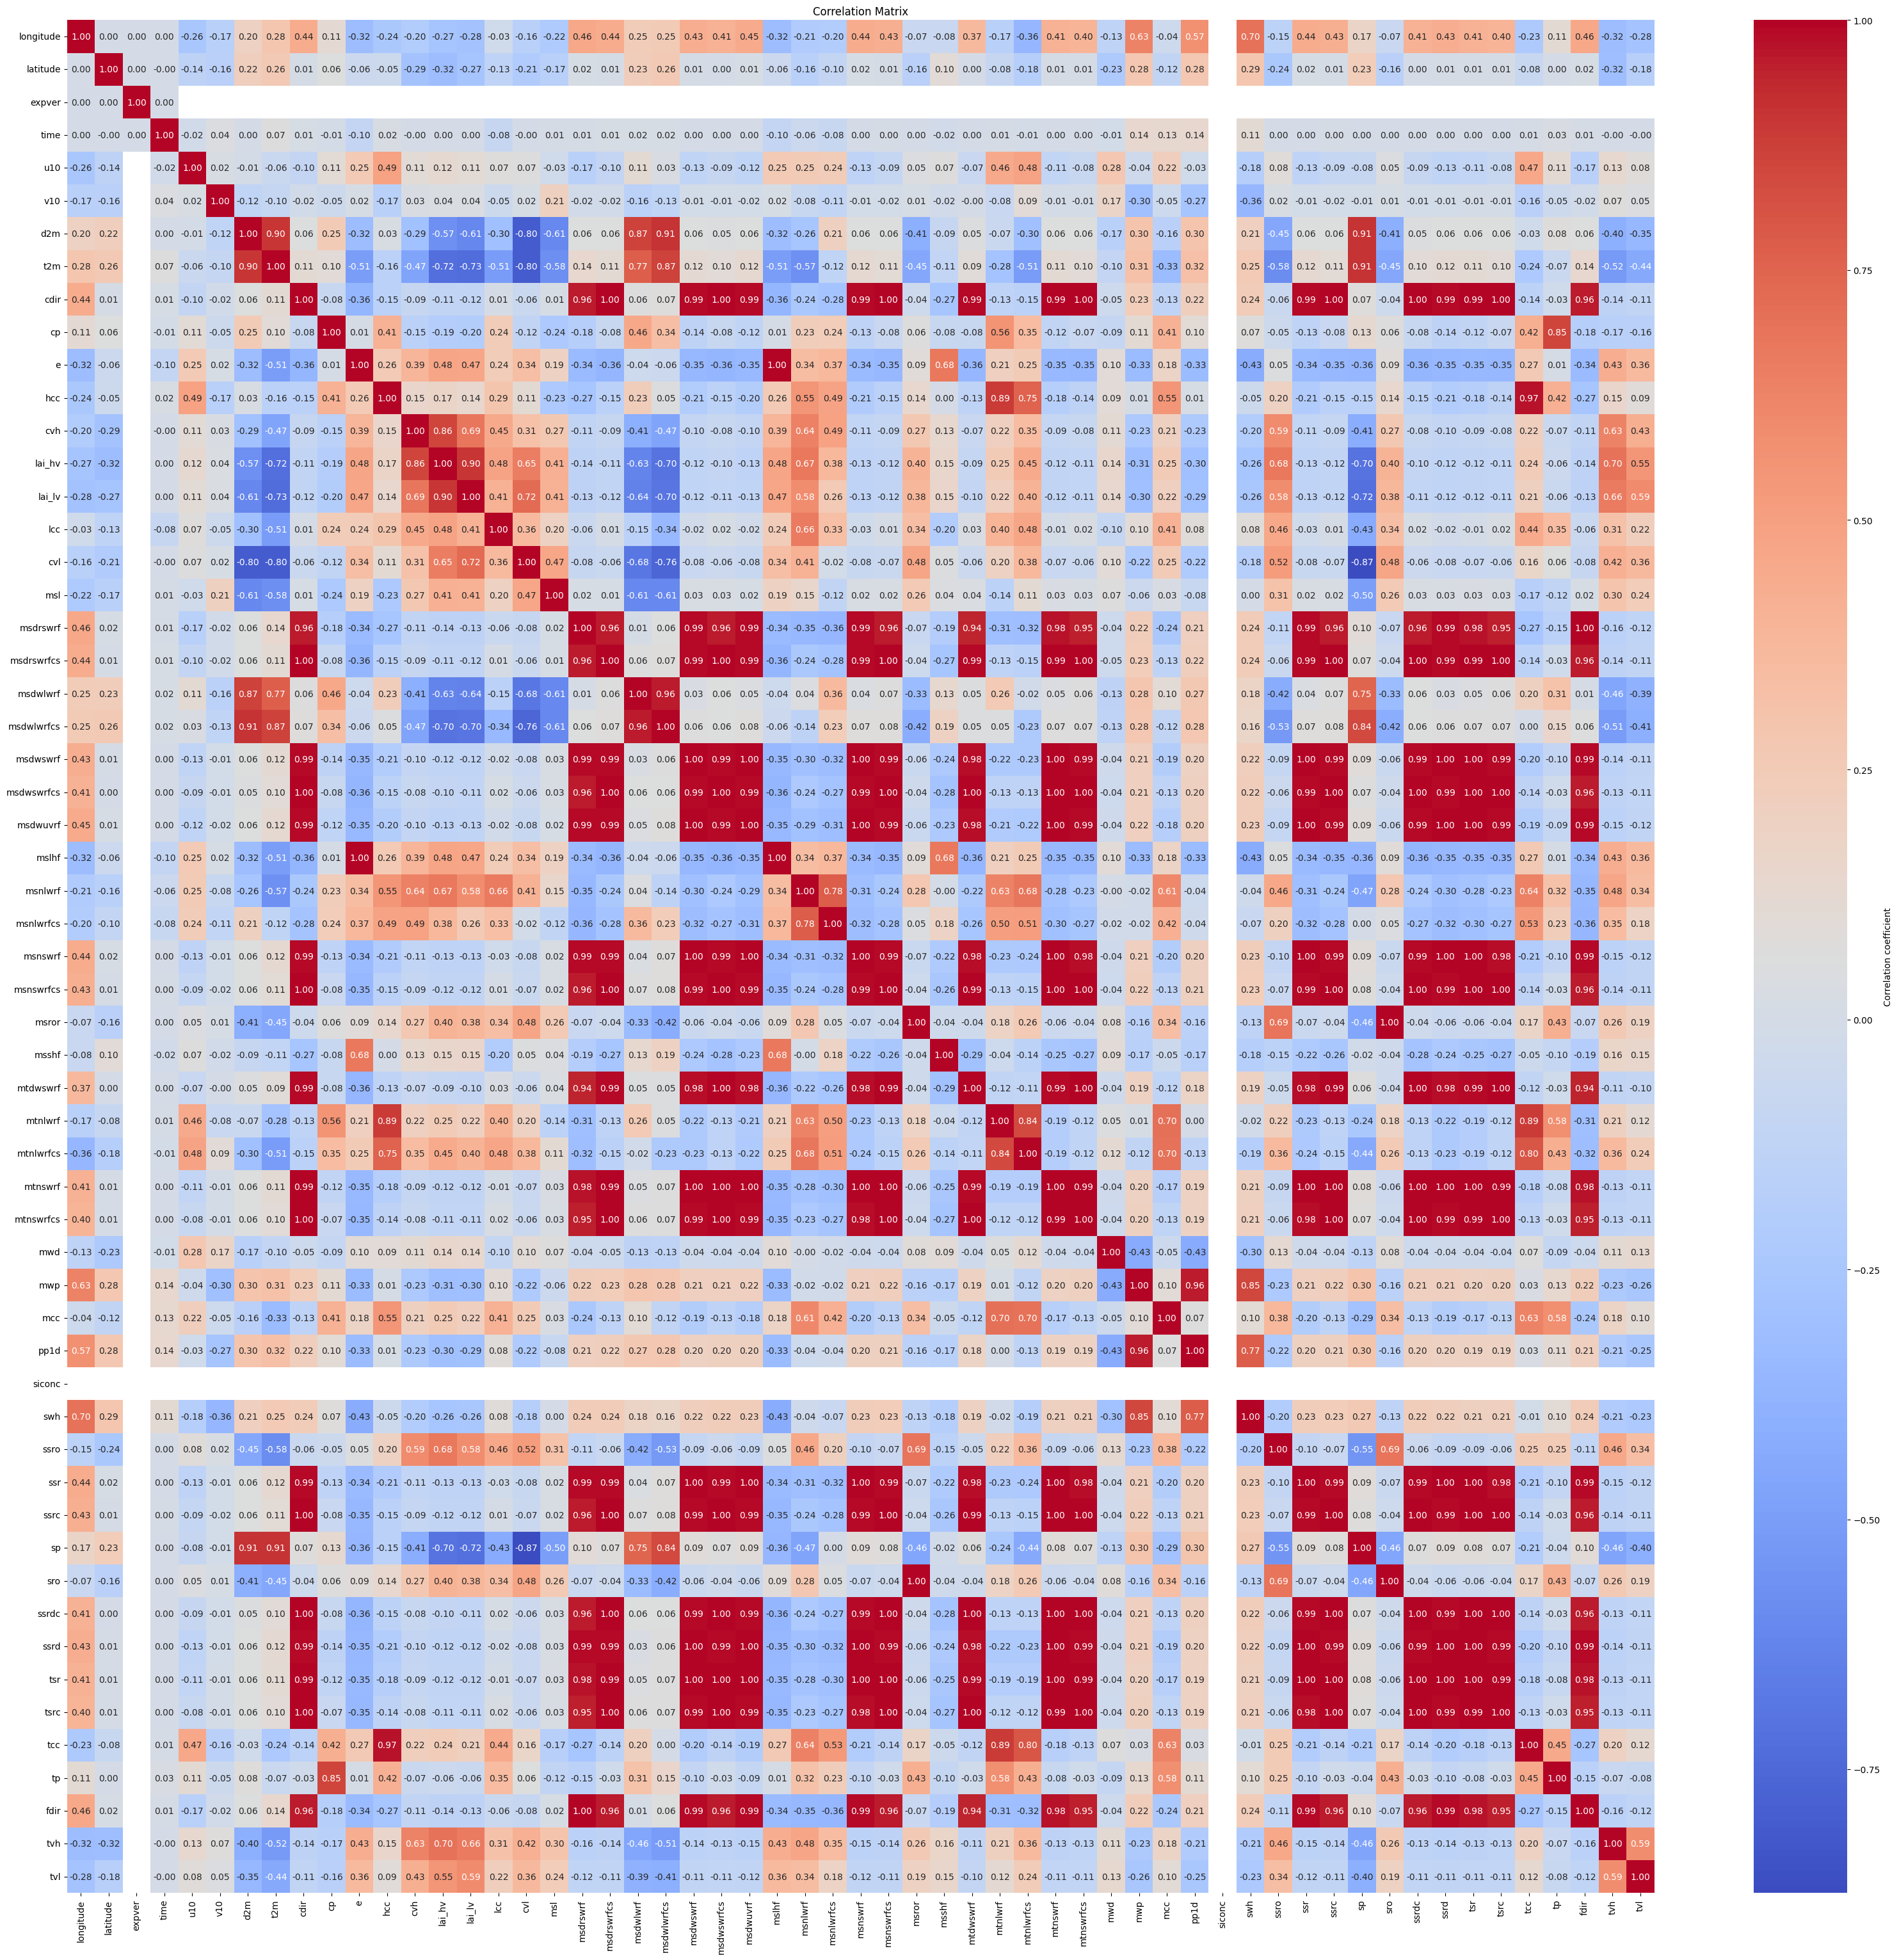

In [8]:
plt.figure(figsize=(40, 38))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix')

plt.show()

## Singular Correlated features we can potentially drop

In [16]:
# Find and display highly correlated features
threshold = 0.95
high_corr = (corr_matrix.abs() >= threshold) & (corr_matrix.abs() < 1.0)
# high_corr = (post_corr_matrix.abs() >= threshold) & (post_corr_matrix.abs() < 1.0)

high_corr_features = high_corr.any()

# correlated_pairs = post_corr_matrix.where(high_corr).stack().reset_index()
correlated_pairs = corr_matrix.where(high_corr).stack().reset_index()
correlated_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
correlated_pairs

Feature1    Feature2  Correlation
0           e       mslhf     1.000000
1         hcc         tcc     0.970929
2    msdwlwrf  msdwlwrfcs     0.956137
3  msdwlwrfcs    msdwlwrf     0.956137
4       mslhf           e     1.000000
5       msror         sro     1.000000
6         mwp        pp1d     0.960404
7        pp1d         mwp     0.960404
8         sro       msror     1.000000
9         tcc         hcc     0.970929

In [17]:
len(correlated_pairs['Feature1'].unique())

10

## Features which are highly correlated with more than four features

In [13]:
# Count the number of high correlations for each feature
high_corr_count = (corr_matrix.abs() >= threshold).sum() - 1  # subtract 1 to exclude self-correlation

# Identify features with more than 4 high correlations
features_to_remove = high_corr_count[high_corr_count > 4].index.tolist()
print("Features to remove:", features_to_remove)
print("Length :",len(features_to_remove))

Features to remove: ['cdir', 'msdrswrf', 'msdrswrfcs', 'msdwswrf', 'msdwswrfcs', 'msdwuvrf', 'msnswrf', 'msnswrfcs', 'mtdwswrf', 'mtnswrf', 'mtnswrfcs', 'ssr', 'ssrc', 'ssrdc', 'ssrd', 'tsr', 'tsrc', 'fdir']
Length : 18


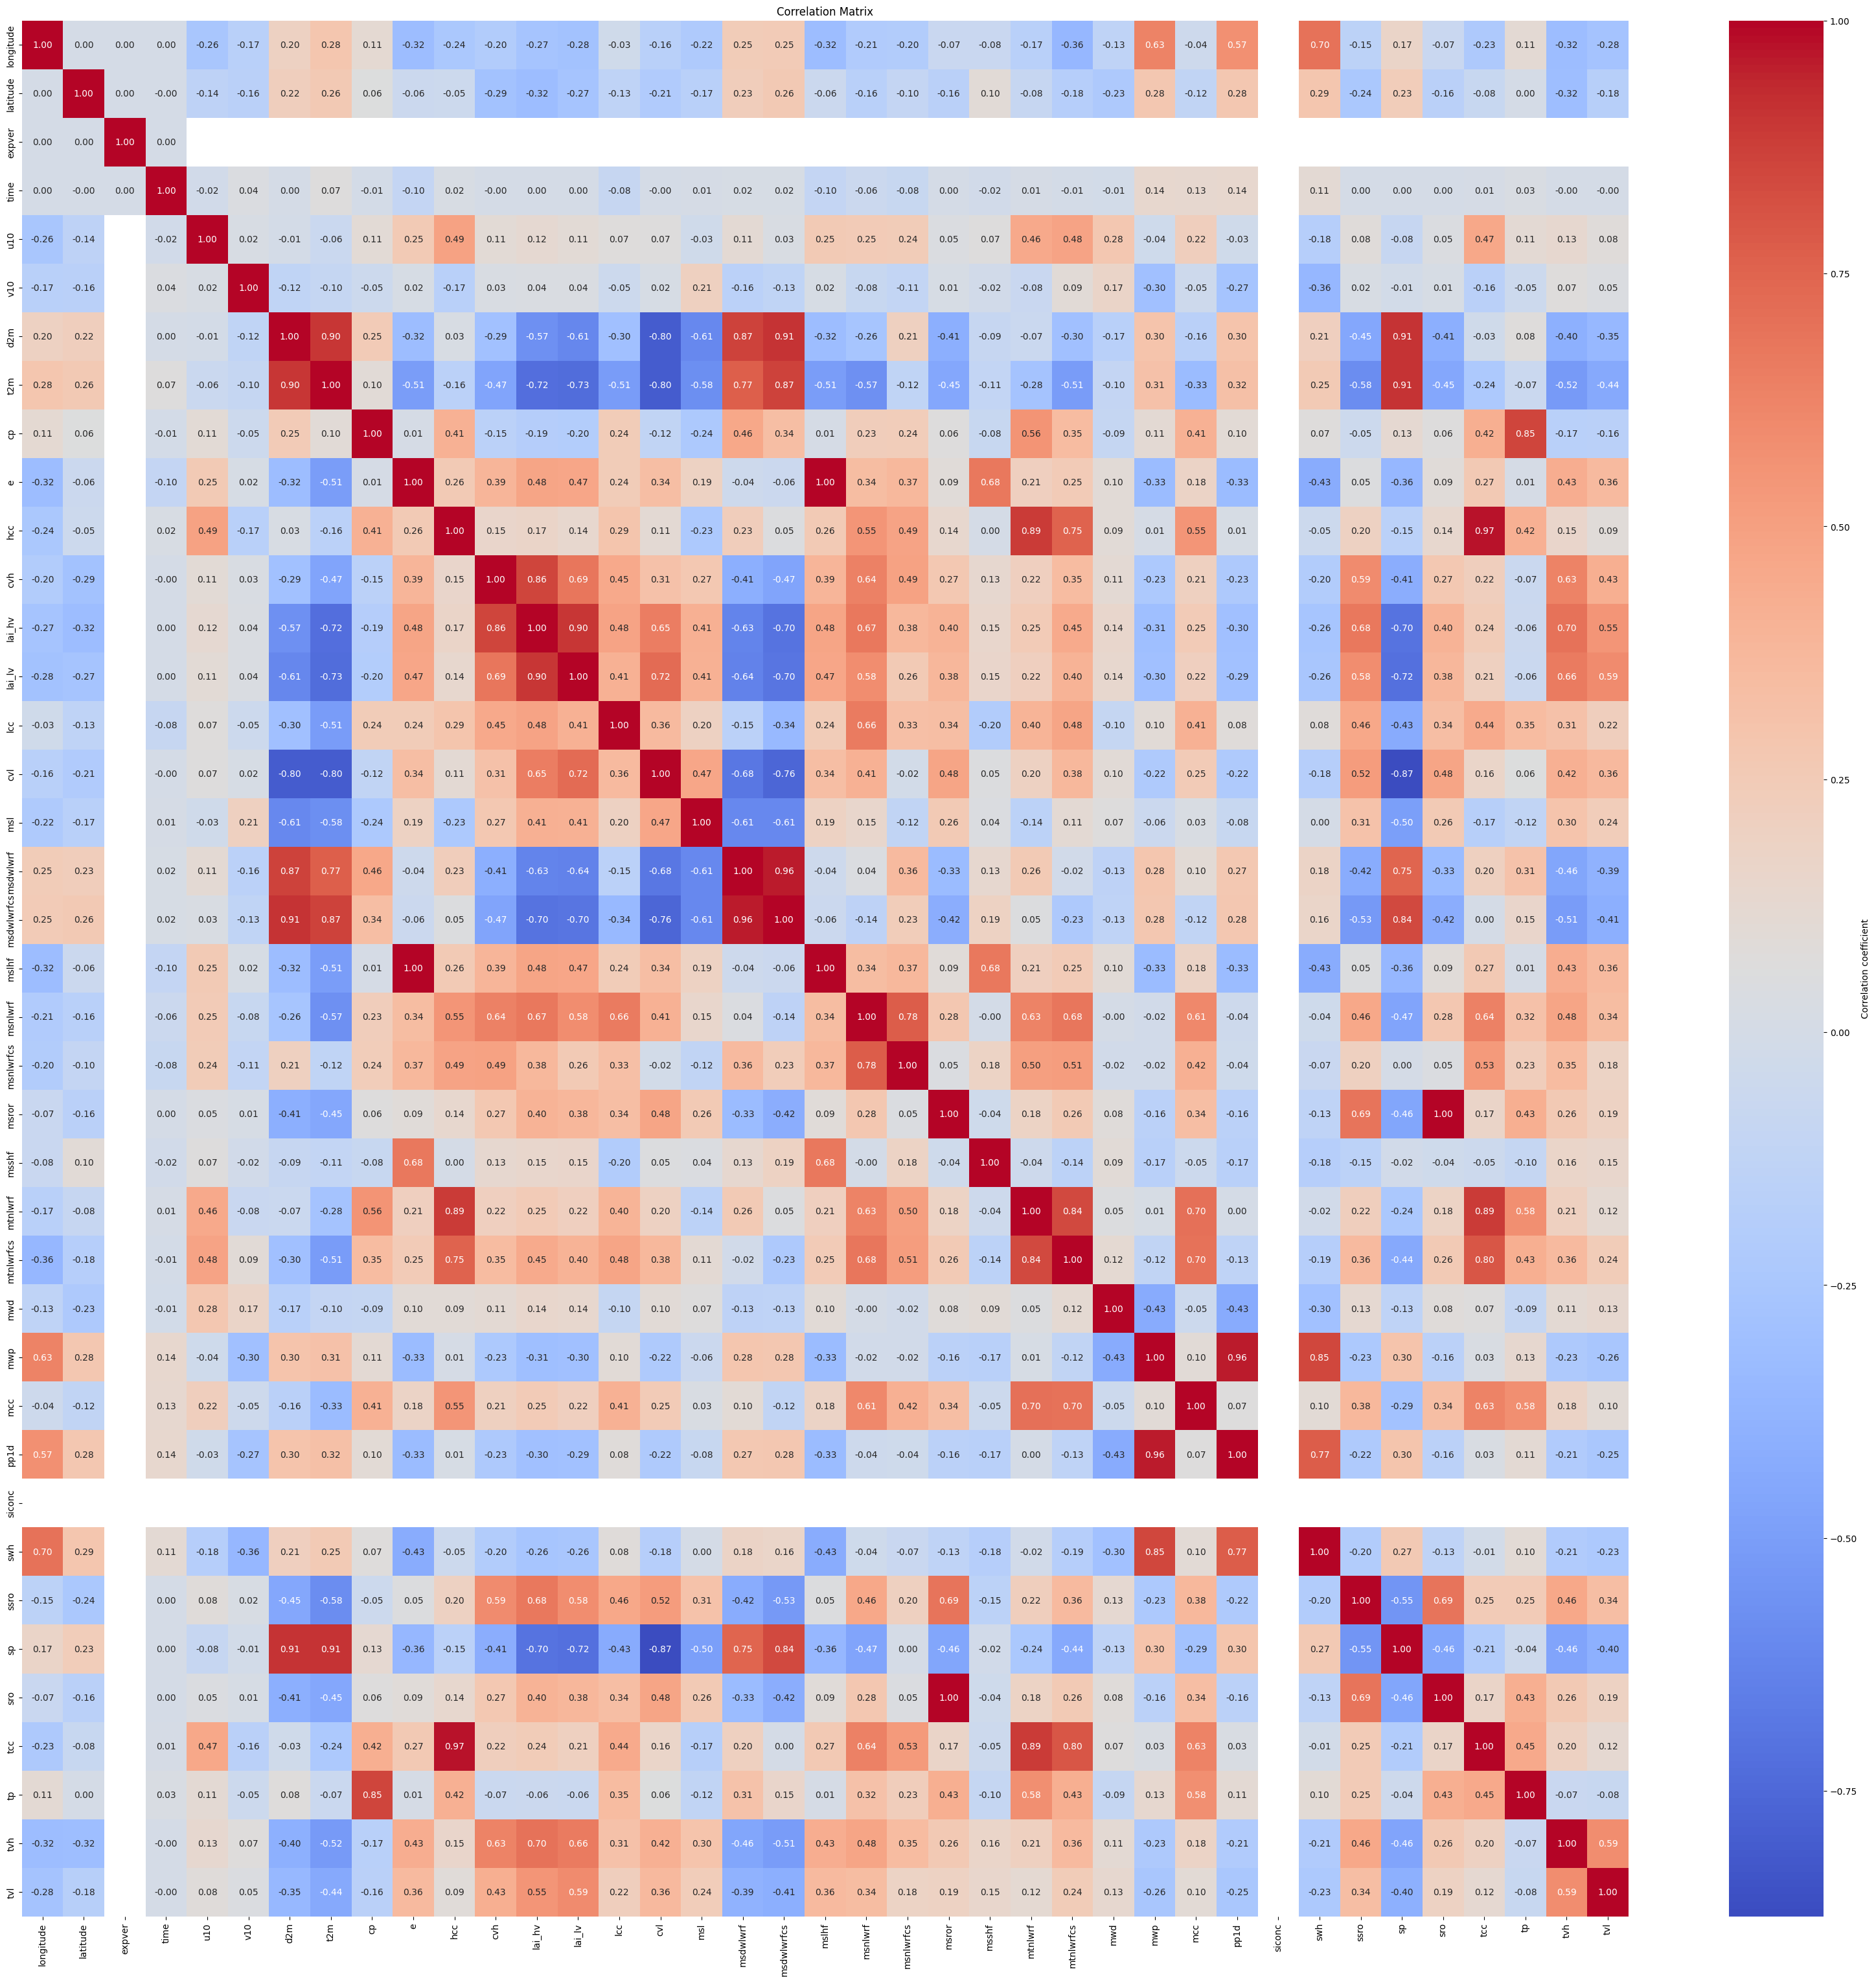

In [14]:
# features_to_remove = ['cdir', 'msdrswrf', 'msdrswrfcs', 'msdwswrf', 'msdwswrfcs', 'msdwuvrf', 'msnswrf', 'msnswrfcs', 'mtdwswrf', 'mtnswrf', 'mtnswrfcs', 'ssr', 'ssrc', 'ssrdc', 'ssrd', 'tsr', 'tsrc', 'fdir']
post_corr_matrix = chunk.drop(columns=['sst']+features_to_remove).corr()
plt.figure(figsize=(40, 38))
sns.heatmap(post_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix')
plt.show()

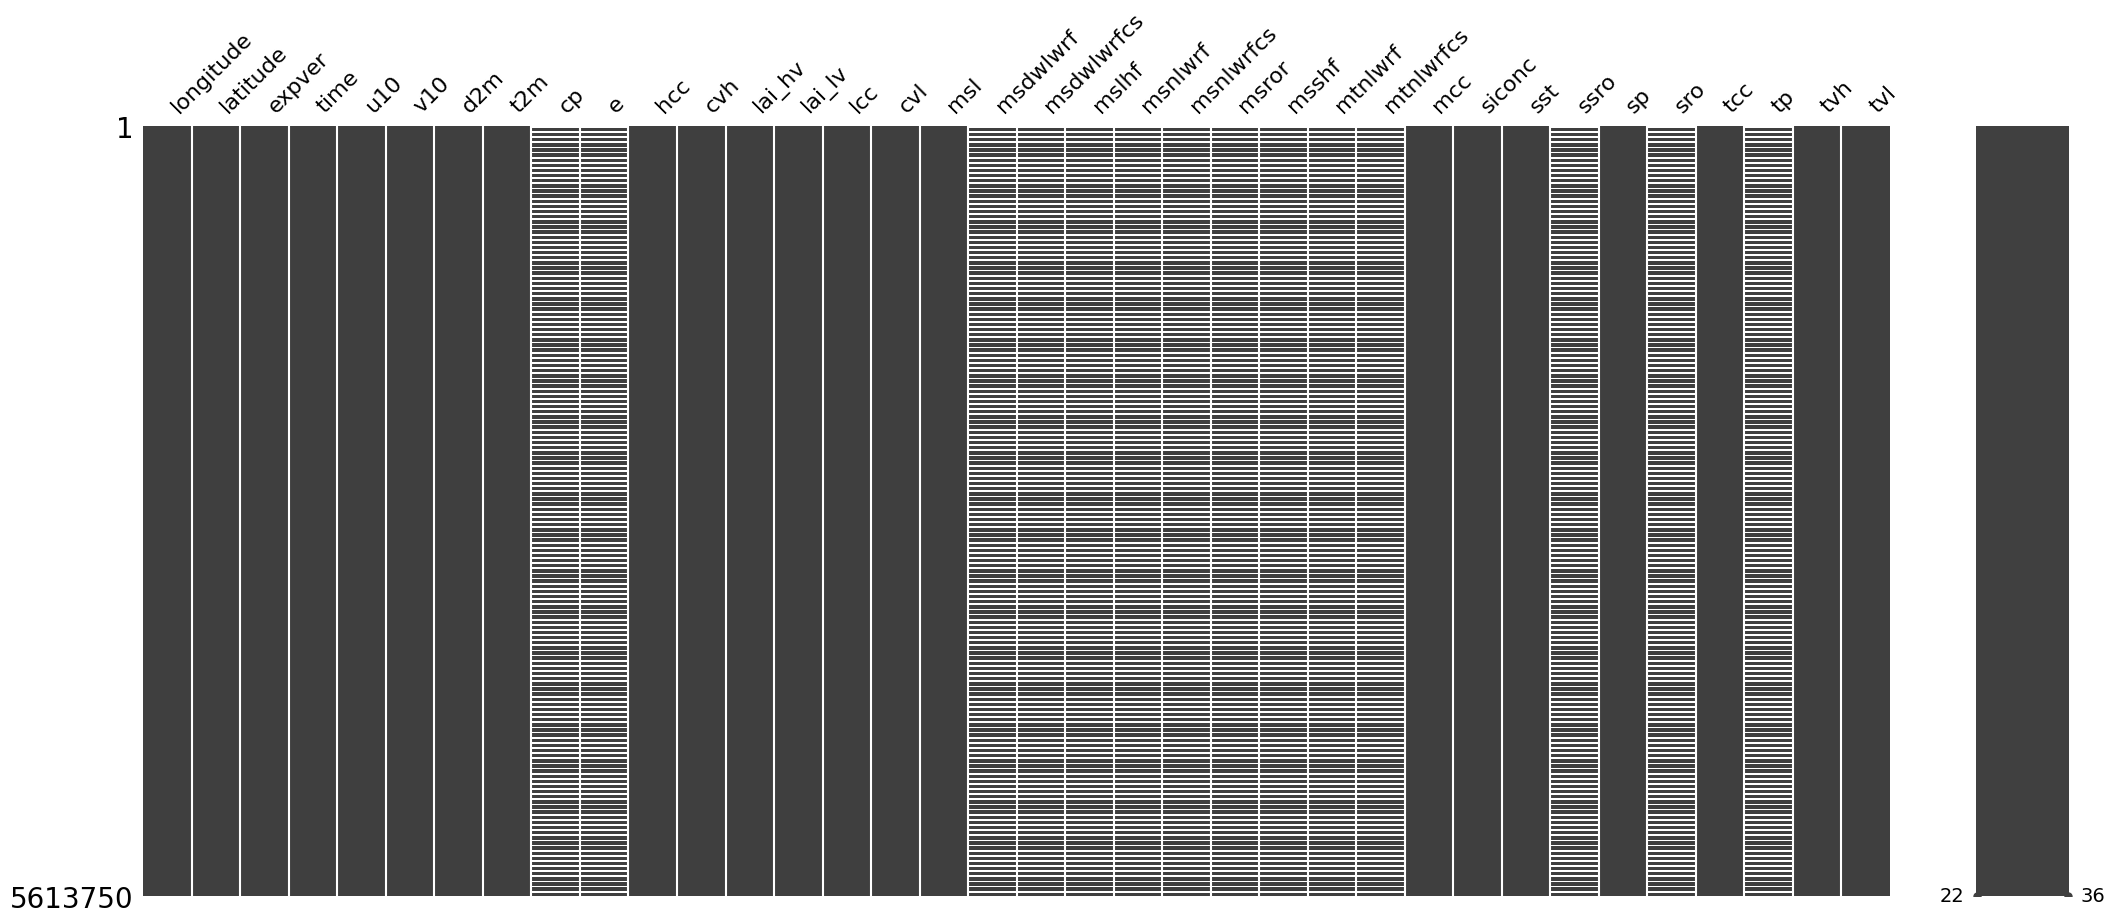

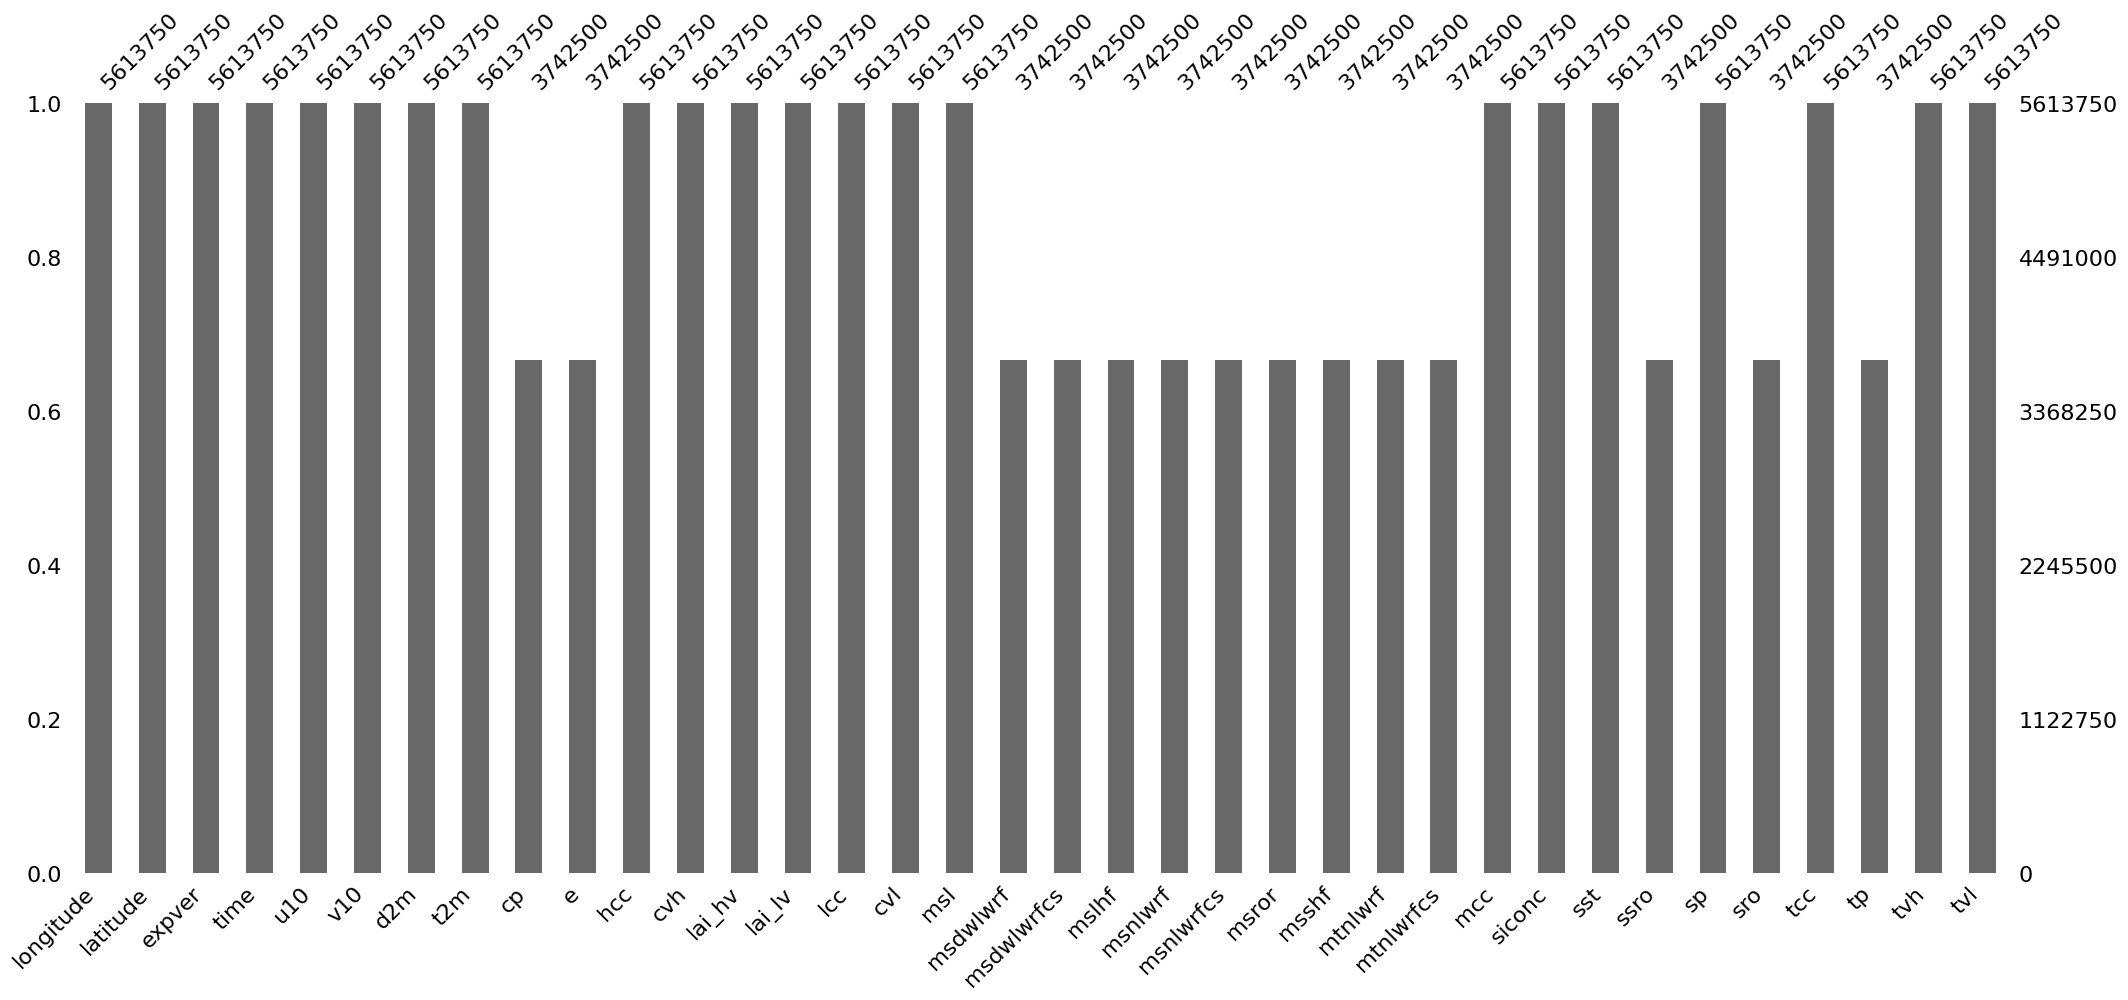

In [23]:
import missingno as msno
# Visualizing the missing data pattern
msno.matrix(chunk)  # Visualize a sample due to large dataset size
plt.show()

# Bar chart for the number of missing values in each column
msno.bar(chunk)
plt.show()

# Heatmap to see correlations of missingness between features
# msno.heatmap(df)
# plt.show()

In [51]:
nan_lengths = []
current_length = 0

for value in tqdm(chunk['mslhf']):
    if np.isnan(value):
        current_length += 1
    else:
        if current_length > 0:
            nan_lengths.append(current_length)
        current_length = 0

# Catch any remaining sequence at the end of the column
if current_length > 0:
    nan_lengths.append(current_length)

# Print the lengths of continuous NaNs
# print(nan_lengths)

100%|██████████| 5613750/5613750 [00:14<00:00, 395102.69it/s]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [55]:
chunk.columns

Index(['longitude', 'latitude', 'expver', 'time', 'u10', 'v10', 'd2m', 't2m',
       'cp', 'e', 'hcc', 'cvh', 'lai_hv', 'lai_lv', 'lcc', 'cvl', 'msl',
       'msdwlwrf', 'msdwlwrfcs', 'mslhf', 'msnlwrf', 'msnlwrfcs', 'msror',
       'msshf', 'mtnlwrf', 'mtnlwrfcs', 'mcc', 'siconc', 'sst', 'ssro', 'sp',
       'sro', 'tcc', 'tp', 'tvh', 'tvl'],
      dtype='object')

## Identifying Normalizing/Scaling needs for each feature

## Pre-processing - Normalizing/Scaling

In [ ]:
df['time']

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


In [ ]:
# Robust Scaling
time_col = df['time']
sst_col = df['sst']
columns = list(df.columns)
columns.remove("time")
columns.remove("sst")
scaler_robust = RobustScaler()
df_robust = pd.DataFrame(scaler_robust.fit_transform(df.drop(columns = ['time', 'sst'])), columns=columns)
df_robust.insert(0, 'time', time_col)
df_robust.insert(1, 'sst', sst_col)

In [ ]:
import pickle
with open("RobustScaler.pkl", "wb") as file:
    pickle.dump(scaler_robust, file)

In [ ]:
df_robust.to_csv("Cleaned-Processed-ERA5-82-23-three-hrs.csv", index=False)

In [ ]:
df.head()

## Automatic Report Generation using SweetViz

In [ ]:
# Generate the report
report = sv.analyze(df)

# Display the report
report.show_html("cleaned_eda_report.html")  # Opens the report in your default web browser

In [ ]:
df['time'].value_counts()